# 线性回归的从零开始实现

在这一节中，我们将从零开始实现整个方法， 包括数据流水线、模型、损失函数和小批量随机梯度下降优化器。 虽然现代的深度学习框架几乎可以自动化地进行所有这些工作，但从零开始实现可以确保我们真正知道自己在做什么。 同时，了解更细致的工作原理将方便我们自定义模型、自定义层或自定义损失函数。 在这一节中，我们将只使用张量和自动求导。 在之后的章节中，我们会充分利用深度学习框架的优势，介绍更简洁的实现方式。

In [70]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

为了简单起见，我们将根据带有噪声的线性模型构造一个人造数据集。 我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。 我们将使用低维数据，这样可以很容易地将其可视化。 在下面的代码中，我们生成一个包含1000个样本的数据集， 每个样本包含从标准正态分布中采样的2个特征。

根据带有噪声的线性模型构造一个人造数据集。
我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$$

In [71]:
def synthetic_data(w, b, num_examples):  
    """生成y=Xw+b+噪声"""
    # 生成均值为 0、标准差为 1，形状为 (num_examples, len(w)) 的正态分布
    X = torch.normal(0, 1, (num_examples, len(w)))
    # 矩阵乘法运算
    y = torch.matmul(X, w) + b
    # 添加了一个小的高斯噪声
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

`features`中的每一行都包含一个二维数据样本，
`labels`中的每一行都包含一维标签值（一个标量）

In [72]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 0.5394, -0.3325]) 
label: tensor([6.4118])


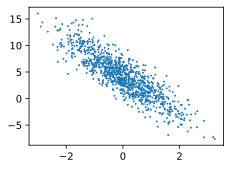

In [73]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。 由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数， 该函数能打乱数据集中的样本并以小批量方式获取数据。

定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量

In [74]:
def data_iter(batch_size, features, labels):
    """
    生成器，每次返回 batch_size（批量大小） 个随机样本的特征和标签
    """
    # 获取样本的总数量
    num_examples = len(features)
    # 创建一个索引列表
    indices = list(range(num_examples))
    # random.shuffle 函数对索引列表进行随机打乱
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        # 获取从 i 开始到 i + batch_size 结束的索引子列表，这将是一个批量的索引
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.8009,  0.0938],
        [ 1.9899,  1.4612],
        [ 0.3038, -0.2243],
        [ 1.4820, -1.1916],
        [-0.6978, -0.4398],
        [-0.7798, -1.3864],
        [ 0.0646, -0.6879],
        [ 0.6364,  0.4091],
        [ 0.0410,  0.0751],
        [ 0.4517, -0.5162]]) 
 tensor([[ 5.4655],
        [ 3.1978],
        [ 5.5697],
        [11.2146],
        [ 4.3040],
        [ 7.3399],
        [ 6.6758],
        [ 4.0929],
        [ 4.0312],
        [ 6.8480]])


当我们运行迭代时，我们会连续地获得不同的小批量，直至遍历完整个数据集。 上面实现的迭代对教学来说很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。 例如，它要求我们将所有数据加载到内存中，并执行大量的随机内存访问。 在深度学习框架中实现的内置迭代器效率要高得多， 它可以处理存储在文件中的数据和数据流提供的数据。

### 初始化模型参数
在我们开始用小批量随机梯度下降优化我们的模型参数之前
我们需要先有一些参数

In [75]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[-0.0082],
         [-0.0008]], requires_grad=True),
 tensor([0.], requires_grad=True))

定义模型，将模型的输入和参数同模型的输出关联起来

In [76]:
def linreg(X, w, b):  
    """线性回归模型"""
    return torch.matmul(X, w) + b

定义损失函数

In [77]:
def squared_loss(y_hat, y):  
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

定义优化算法

In [78]:
def sgd(params, lr, batch_size):  
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

训练过程

In [79]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()  
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.034170
epoch 2, loss 0.000116
epoch 3, loss 0.000046


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [80]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0001,  0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0001], grad_fn=<RsubBackward1>)
